In [1]:
%cd src
!conda run -n simple_env python3 -m numpy.f2py -c -m polyomino_gcmc_simulation polyomino_gcmc_simulation.f90 --opt='-O3'
%cd ..

/Users/daviderevignas/scientific_projects/scientific_code/polyomini/src
running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "polyomino_gcmc_simulation" sources
INFO: f2py options: []
INFO: f2py:> /var/folders/n5/f496lkj93z1d5p8bbkfqkhtr0000gn/T/tmpqgthnwbh/src.macosx-11.0-arm64-3.9/polyomino_gcmc_simulationmodule.c
creating /var/folders/n5/f496lkj93z1d5p8bbkfqkhtr0000gn/T/tmpqgthnwbh/src.macosx-11.0-arm64-3.9
Reading fortran codes...
	Reading file 'polyomino_gcmc_simulation.f90' (format:free)
Post-processing...
	Block: polyomino_gcmc_simulation
			Block: polyomino_gcmc_simulation
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "polyomino_gcmc_simulation"...
 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

import os
from numba import njit
import sys 
module_path = "src"
sys.path.append(module_path)
import polyomino_gcmc_simulation






In [51]:
omino_1 = np.array([[0,0],[0,1],[0,2]],dtype=np.int32)
omino_2 = np.array([[0,0],[0,1],[1,0]],dtype=np.int32)


omino_1 = omino_1[..., np.newaxis]  
omino_2 = omino_2[..., np.newaxis] 


ominos_sizes= np.array([3,3],dtype=np.int32)
max_omino_size=np.max(ominos_sizes)

omino_shapes = np.concatenate([omino_1, omino_2], axis=2)
n_omino_types = omino_shapes.shape[-1]





In [52]:
box_size = 20
initial_n_ominos_per_shape=np.array([1,1],dtype=np.int32)
initial_n_ominos = np.sum(initial_n_ominos_per_shape)

crystal_cell_size_x = 2
crystal_cell_size_y = max_omino_size
crystal_n_cells = (box_size//crystal_cell_size_x)*(box_size//crystal_cell_size_y)

if crystal_n_cells < initial_n_ominos:
    raise ValueError('INCREASE box_size')


crystal_coords=[]
for ix in range(box_size//crystal_cell_size_x):
    for iy in range(box_size//crystal_cell_size_y):
        crystal_coords.append([ix*crystal_cell_size_x+1,iy*crystal_cell_size_y+1])
crystal_coords=np.array(crystal_coords,dtype=np.int32)

crystal_coords_order=np.arange(crystal_n_cells,dtype=np.int32)
np.random.shuffle(crystal_coords_order)
crystal_coords_order=crystal_coords_order[:initial_n_ominos]

initial_positions=crystal_coords[crystal_coords_order]
initial_orientations = np.ones(initial_n_ominos,dtype=np.int32)


In [53]:
# First part: Create vec_omino_types array
i_omino = 0
vec_omino_types = np.zeros(initial_n_ominos, dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    for i_omino_of_type in range(initial_n_ominos_per_shape[i_omino_type - 1]):  # Convert to 0-based indexing
        vec_omino_types[i_omino] = i_omino_type
        i_omino += 1

# Second part: Create rotated shapes array
rot_omino_shapes = np.zeros((max_omino_size, 2, n_omino_types, 4), dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    omino_type_idx = i_omino_type - 1  # Convert to 0-based for array indexing
    
    for i_cell in range(ominos_sizes[omino_type_idx]):  # 0 to ominos_sizes-1
        # Get original coordinates (convert from 1-based to 0-based indexing)
        orig_x = omino_shapes[i_cell, 0, omino_type_idx]
        orig_y = omino_shapes[i_cell, 1, omino_type_idx]
        
        # Rotation 1: 0 degrees clockwise (x,y) -> (x,y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 0] = orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 0] = orig_y
        
        # Rotation 2: 90 degrees clockwise (x,y) -> (-y,x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 1] = -orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 1] = orig_x
        
        # Rotation 3: 180 degrees (x,y) -> (-x,-y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 2] = -orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 2] = -orig_y
        
        # Rotation 4: 270 degrees clockwise (x,y) -> (y,-x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 3] = orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 3] = -orig_x


In [54]:
initial_n_ominos,initial_n_ominos_per_shape,initial_positions,initial_orientations

(2,
 array([1, 1], dtype=int32),
 array([[ 3, 10],
        [ 7, 16]], dtype=int32),
 array([1, 1], dtype=int32))

In [55]:
n_savings=1000

n_mc_steps=3000*n_savings

save_every=n_mc_steps//n_savings
prng_seed=np.random.randint(1,100000)

max_n_ominos=5000
move_probabilities=np.array([0.0,0.0,0.5,0.5])

mu_1=5.0
mu_2_to_do=np.linspace(0.0,20.0,11)
# mu_2_to_do=[5.0]

all_results=[]

for i_mu_2 in range(len(mu_2_to_do)):


    chemical_potentials=np.array([mu_1,mu_2_to_do[i_mu_2]])

    start_time = time.time()
    system_snapshots,history_positions,history_orientations,history_n_ominos,\
        history_n_ominos_per_shape,history_vec_omino_types = polyomino_gcmc_simulation.polyomino_gcmc_simulation(
        n_mc_steps=n_mc_steps,
        n_savings=n_savings,
        n_omino_types=n_omino_types,
        ominos_sizes=ominos_sizes,
        max_omino_size=max_omino_size,
        omino_shapes=omino_shapes,
        initial_n_ominos_per_shape=initial_n_ominos_per_shape, 
        initial_n_ominos=initial_n_ominos,
        initial_positions=initial_positions,
        initial_orientations=initial_orientations,
        max_n_ominos=max_n_ominos,
        chemical_potentials=chemical_potentials,
        move_probabilities=move_probabilities,
        box_size=box_size,
        prng_seed=prng_seed
    )
    all_results.append(
        {   
            'chemical_potentials':chemical_potentials,
            'system_snapshots':system_snapshots,
            'history_positions':history_positions,
            'history_orientations':history_orientations,
            'history_n_ominos':history_n_ominos,
            'history_n_ominos_per_shape':history_n_ominos_per_shape,
            'history_vec_omino_types':history_vec_omino_types,
        }
    )

    end_time = time.time()
    execution_time = end_time - start_time
    # print(f"Execution time: {execution_time:.2f} seconds")

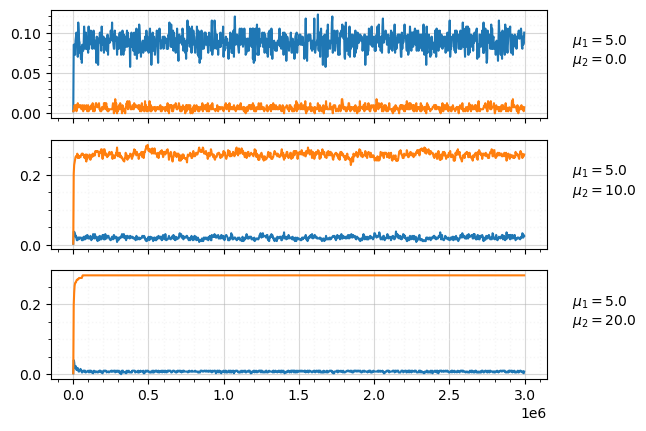

In [ ]:
ind_to_plot_trajectories=[0,(len(all_results)-1)//2,len(all_results)-1]
fig,axs=plt.subplots(nrows=len(ind_to_plot_trajectories),sharex=True)
x_to_plot_trajectory=np.arange(n_savings)*save_every
for ax in axs.flatten():
    ax.grid(alpha=0.5, which='both')
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    ax.minorticks_on()
    ax.set_axisbelow(True)


for i_ax, ind in enumerate(ind_to_plot_trajectories):
    ax=axs.flatten()[i_ax]
    ax.plot(x_to_plot_trajectory,all_results[ind]['history_n_ominos_per_shape'][0,:]/box_size**2)
    ax.plot(x_to_plot_trajectory,all_results[ind]['history_n_ominos_per_shape'][1,:]/box_size**2)
    ax.text(1.05,0.5,f"$\mu_1={all_results[ind]['chemical_potentials'][0]:}$\
\n$\mu_2={all_results[ind]['chemical_potentials'][1]:}$",transform=ax.transAxes)

34 34
109 109
116 116


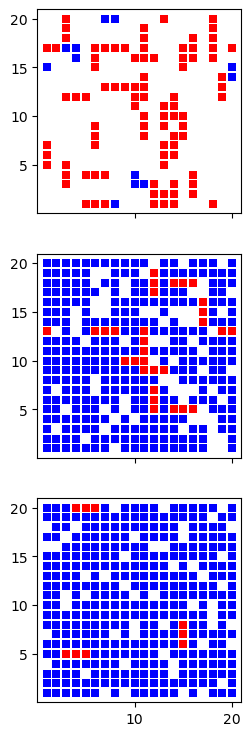

In [64]:
i_snapshot=800

fig,axs=plt.subplots(nrows=len(ind_to_plot_trajectories),figsize=(3,3*len(ind_to_plot_trajectories)),sharex=True)

for i_ax, ind in enumerate(ind_to_plot_trajectories):
    ax=axs.flatten()[i_ax]    
    ax.set_aspect('equal', 'box')   

    history_vec_omino_types=all_results[ind]['history_vec_omino_types']
    history_positions=all_results[ind]['history_positions']
    history_orientations=all_results[ind]['history_orientations']
    history_n_ominos=all_results[ind]['history_n_ominos']
    n_ominos, _, n_snapshots = history_positions.shape
    current_system_state=np.zeros((box_size,box_size),dtype=np.int32)
    for i_omino in range(history_n_ominos[i_snapshot]):
        i_omino_type = history_vec_omino_types[i_omino,i_snapshot] - 1  # Convert to 0-based indexing
        current_position = history_positions[i_omino, :, i_snapshot]
        current_orientation = history_orientations[i_omino, i_snapshot] - 1  # Convert to 0-based
        omino_size = ominos_sizes[i_omino_type]
        for i_cell in range(omino_size):
                # Calculate cell position with rotation and periodic boundaries
                ix_cell = ((current_position[0] - 1 + 
                        rot_omino_shapes[i_cell, 0, i_omino_type, current_orientation]) 
                        % box_size)
                iy_cell = ((current_position[1] - 1 + 
                        rot_omino_shapes[i_cell, 1, i_omino_type, current_orientation]) 
                        % box_size)

                # Store omino type (1-based for visualization)
                current_system_state[int(ix_cell), int(iy_cell)] = i_omino_type + 1
    
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink']
        block_size_plot = 120/box_size

        for ix in range(box_size):
                for iy in range(box_size):
                        omino_type = current_system_state[ix, iy]
                        if omino_type > 0:  # If cell is occupied
                                color_idx = (omino_type - 1) % len(colors)  # Cycle through colors
                                
                                sc = ax.plot(ix+1, iy+1, 
                                        marker='s',
                                        color=colors[color_idx],
                                        markersize=block_size_plot,
                                        markeredgewidth=0.0,
                                        markeredgecolor='black')
    print((current_system_state>0).sum()//3,history_n_ominos[i_snapshot])


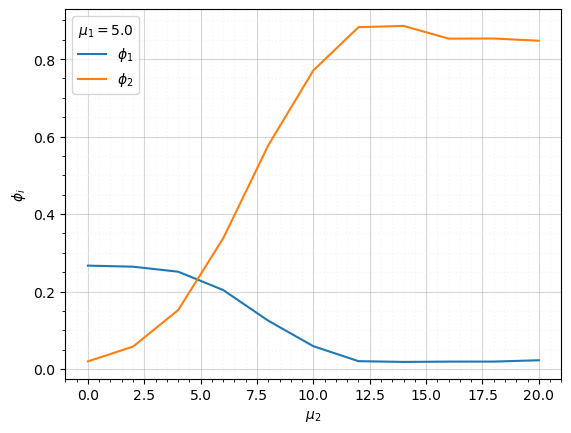

In [75]:
fig,ax=plt.subplots()
ax.grid(alpha=0.5, which='both')
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True)

n_equilibration=100
all_ave_n_ominos_per_shape=[]
for i_mu_2 in range(len(mu_2_to_do)):
    all_ave_n_ominos_per_shape.append(
        all_results[i_mu_2]['history_n_ominos_per_shape'][:,n_equilibration:].mean(axis=1)
    )

all_ave_n_ominos_per_shape=np.array(all_ave_n_ominos_per_shape)

for i_omino_type in range(n_omino_types):
    ax.plot(mu_2_to_do,
            ominos_sizes[i_omino_type]*all_ave_n_ominos_per_shape[:,i_omino_type]/box_size**2,
            label=f"$\phi_{i_omino_type+1:}$")

ax.set_xlabel('$\mu_2$')
ax.set_ylabel('$\phi_{i}$')
ax.legend(title=f'$\mu_1={mu_1:}$')